
### ✅ Task 1: Data Preprocessing & Exploratory Data Analysis
## **Time Series Forecasting for Portfolio Management**
- **Analyst**: GMF Investments
- **Date**: August 10, 2025
#### This notebook loads, cleans, and explores financial data for TSLA, BND, and SPY from July 1, 2015, to July 31, 2025.

In [47]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [53]:
import os
import yfinance as yf
import pandas as pd

# --- 1. Set fixed CA bundle ---
os.environ['REQUESTS_CA_BUNDLE'] = 'C:/ssl/certs/cacert.pem'

# --- 2. Download data with group_by='column' ---
tickers = ['TSLA', 'BND', 'SPY']
data = yf.download(
    tickers,
    start='2015-07-01',
    end='2025-07-31',
    group_by='column',  # Recommended
    progress=True,
    auto_adjust=False   # Keeps 'Adj Close' separate
)

# --- 3. Check if download succeeded ---
if data.empty:
    raise ValueError("Failed to download data. Check your internet connection and SSL setup.")

print("Data columns:", data['Adj Close'].columns)  # Should show: Index(['BND', 'SPY', 'TSLA'], dtype='object')

# --- 4. Extract Adjusted Close ---
prices = pd.DataFrame({
    'TSLA': data['Adj Close']['TSLA'],
    'BND': data['Adj Close']['BND'],
    'SPY': data['Adj Close']['SPY']
})

# --- 5. Clean any missing values ---
prices.dropna(inplace=True)

print("✅ Final prices DataFrame created. Shape:", prices.shape)
print(prices.head())

DEBUG:yfinance:Entering download()
DEBUG:yfinance:Disabling multithreading because DEBUG logging enabled
DEBUG:yfinance: Entering history()
DEBUG:peewee:('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['TSLA', 1, 0])
DEBUG:yfinance:  Entering history()
DEBUG:yfinance:TSLA: Yahoo GET parameters: {'period1': '2015-07-01 00:00:00-04:00', 'period2': '2025-07-31 00:00:00-04:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG:yfinance:TSLA: yfinance received OHLC data: 2015-07-01 13:30:00 -> 2025-07-30 13:30:00
DEBUG:yfinance:TSLA: OHLC after cleaning: 2015-07-01 09:30:00-04:00 -> 2025-07-30 09:30:00-04:00
DEBUG:yfinance:TSLA: OHLC after combining events: 2015-07-01 00:00:00-04:00 -> 2025-07-30 00:00:00-04:00
DEBUG:yfinance:TSLA: yfinance returning OHLC: 2015-07-01 00:00:00-04:00 -> 2025-07-30 00:00:00-04:00
DEBUG:yfinance:  Exiting history()
DEBUG:yfinance: Exiting history()
DEBUG:yfinance: Entering histor

Data columns: Index(['BND', 'SPY', 'TSLA'], dtype='object', name='Ticker')
✅ Final prices DataFrame created. Shape: (2535, 3)
                 TSLA        BND         SPY
Date                                        
2015-07-01  17.943333  60.816734  174.917114
2015-07-02  18.667999  60.967102  174.756882
2015-07-06  18.648001  61.177582  174.259567
2015-07-07  17.858667  61.237717  175.355438
2015-07-08  16.997334  61.410648  172.413437


In [54]:
# Data cleaning
print("Missing values:", prices.isnull().sum().sum())
prices.dropna(inplace=True)

# Validate data types
print(prices.dtypes)


Missing values: 0
TSLA    float64
BND     float64
SPY     float64
dtype: object


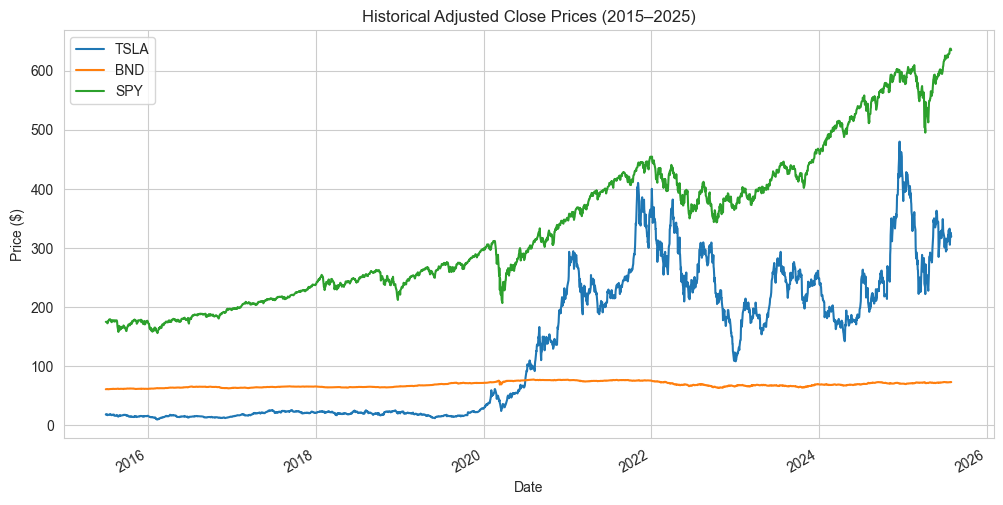

In [55]:
# Plot closing prices
prices.plot(title='Historical Adjusted Close Prices (2015–2025)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

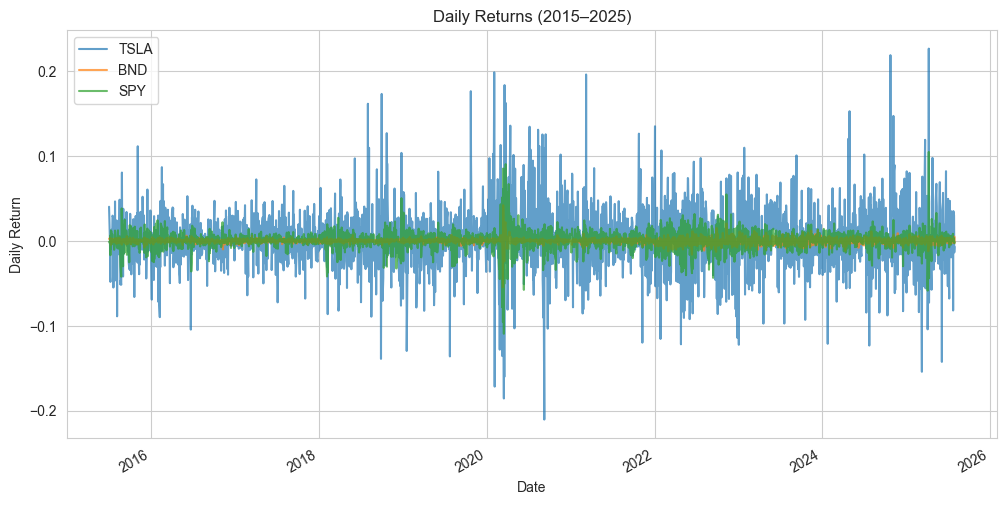

In [56]:
# Daily returns
returns = prices.pct_change().dropna()
returns.plot(title='Daily Returns (2015–2025)', alpha=0.7)
plt.ylabel('Daily Return')
plt.show()

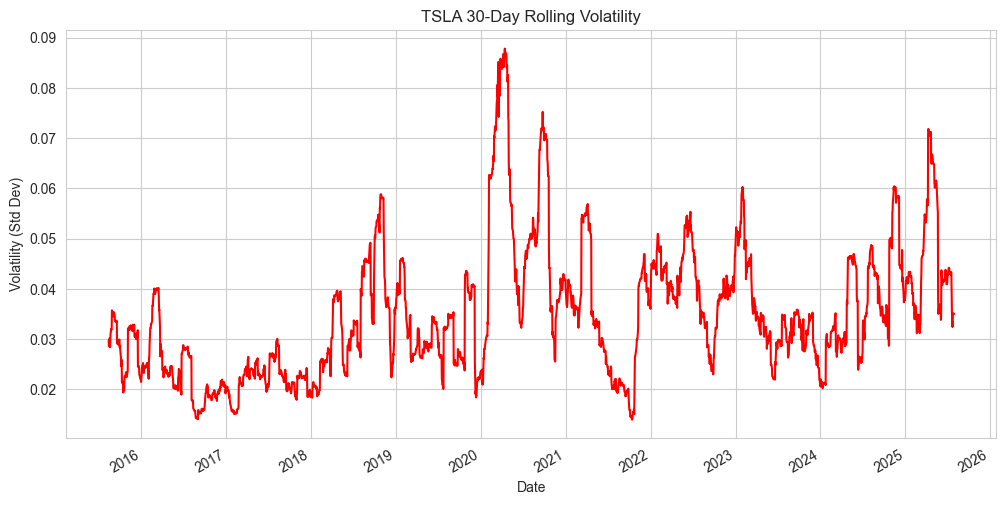

In [57]:
# Rolling volatility (30-day)
rolling_vol = returns['TSLA'].rolling(30).std()
rolling_vol.plot(title='TSLA 30-Day Rolling Volatility', color='red')
plt.ylabel('Volatility (Std Dev)')
plt.show()

In [58]:
# Outlier detection (Z-score > 3)
z_scores = np.abs((returns - returns.mean()) / returns.std())
outliers = z_scores[z_scores > 3]
print("Outlier Days (Z > 3):")
print(outliers.stack().reset_index().rename(columns={0: 'Z-Score'}).head(10))

Outlier Days (Z > 3):
        Date level_1   Z-Score
0 2015-08-24     SPY  3.714486
1 2015-08-26     SPY  3.291303
2 2016-06-24     SPY  3.175136
3 2018-02-05     SPY  3.689753
4 2018-02-08     SPY  3.314345
5 2018-08-02    TSLA  4.292619
6 2018-09-28    TSLA  3.777444
7 2018-10-01    TSLA  4.603497
8 2018-10-23    TSLA  3.362199
9 2018-12-26     SPY  4.347046


In [59]:
# Stationarity test (ADF)
def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f"ADF Test: {title}")
    print(f"Statistic: {result[0]:.4f}, p-value: {result[1]:.6f}")
    print("→ Stationary" if result[1] <= 0.05 else "→ Non-Stationary")

adf_test(prices['TSLA'], 'TSLA Price')
adf_test(returns['TSLA'], 'TSLA Returns')

ADF Test: TSLA Price
Statistic: -1.4189, p-value: 0.573196
→ Non-Stationary
ADF Test: TSLA Returns
Statistic: -34.6811, p-value: 0.000000
→ Stationary


In [60]:
# Risk metrics
var_95 = returns.quantile(0.05)
sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

print("\n5% VaR (Daily Loss):")
print(var_95.round(3))
print("\nAnnualized Sharpe Ratio:")
print(sharpe.round(3))

# Save for next tasks
prices.to_csv('../data/prices.csv')
returns.to_csv('../data/returns.csv')
print("\n✅ Data saved to '../data/' folder.")


5% VaR (Daily Loss):
TSLA   -0.055
BND    -0.005
SPY    -0.017
Name: 0.05, dtype: float64

Annualized Sharpe Ratio:
TSLA    0.778
BND     0.357
SPY     0.794
dtype: float64

✅ Data saved to '../data/' folder.
